In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import csv  
import time
import os, datetime
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import tensorflow as tf
import pandas_datareader as pdr
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')


Tensorflow version: 2.8.0


## Hyperparameters

In [2]:
batch_size = 64
seq_len = 128

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

## Load Microsoft data

In [3]:
# df = pdr.get_data_tiingo("MSFT", api_key="aeeaa9dbc8f82f2c361abaa259050d75e736b424")

ticker = yf.Ticker("MSFT")
df = ticker.history(period="max")


df.to_csv("MSFT.csv")
df = pd.read_csv("MSFT.csv", delimiter=',', usecols=['Date', 'Close'])
df.sort_values('Date', inplace=True)
price_history = df
df = df["Close"]
prices = price_history[["Close"]].pct_change().dropna()

df

0         0.061252
1         0.063439
2         0.064533
3         0.062892
4         0.061799
           ...    
9098    280.519989
9099    285.299988
9100    286.359985
9101    280.809998
9102    276.019989
Name: Close, Length: 9103, dtype: float64

In [4]:
prices

,Close
1,0.035712
2,0.017250
3,-0.025431
4,-0.017390
5,-0.026548
...,...
9098,0.002466
9099,0.017040
9100,0.003715
9101,-0.019381


## Calculate normalized percentage change of all columns

In [6]:

'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series
last_30pct = sorted(df.index.values)[-int(0.3*len(times))] # Last 30% of series



In [7]:
# Min-max normalize price columns (0-1 range)
# df_temp = df[['Open','High','Low','Close']]
scaler_1 = MinMaxScaler(feature_range=(0, 1))
df = scaler_1.fit_transform(np.array(df).reshape(-1,1))
df

array([[1.27789993e-05],
       [1.91685588e-05],
       [2.23651177e-05],
       ...,
       [8.36299636e-01],
       [8.20087961e-01],
       [8.06096208e-01]])

In [8]:
scaler_2 = MinMaxScaler()
df_prices = scaler_2.fit_transform(prices)
df_prices

array([[0.67806707],
       [0.64090564],
       [0.55499505],
       ...,
       [0.61366259],
       [0.567173  ],
       [0.57184948]])

In [9]:
df = pd.DataFrame(df,columns=['Close'])
# scaler_2 = MinMaxScaler(feature_range=(0, 1))
# df['Volume'] = scaler_1.fit_transform(np.array(df['Volume']).reshape(-1, 1))
df.replace(0, np.nan, inplace=True)
df.dropna(how='any', axis=0, inplace=True)
# df.reset_index(inplace=True)
df

,Close
0,0.000013
1,0.000019
2,0.000022
3,0.000018
4,0.000014
...,...
9098,0.819241
9099,0.833203
9100,0.836300
9101,0.820088


In [10]:
df = pd.DataFrame(df_prices,columns=['Close'])
df

,Close
0,0.678067
1,0.640906
2,0.554995
3,0.571180
4,0.552748
...,...
9097,0.611147
9098,0.640482
9099,0.613663
9100,0.567173


In [11]:
'''Create training, validation and test split'''

df_train = df[(df.index < last_30pct)]  # Training data are 70% of total data
df_val = df[(df.index >= last_30pct) & (df.index < last_20pct)]
df_test = df[(df.index >= last_20pct)]

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (6373, 1)
Validation data shape: (910, 1)
Test data shape: (1819, 1)


,Close
0,0.678067
1,0.640906
2,0.554995
3,0.571180
4,0.552748


## Plot daily changes of close prices and volume

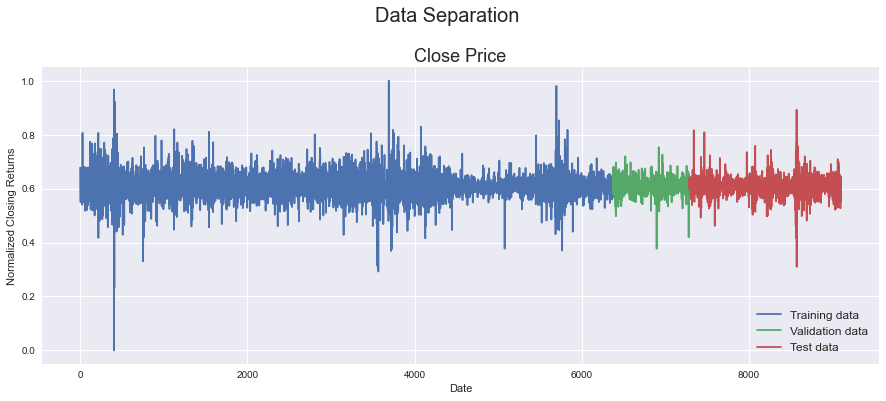

In [12]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train, label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val, label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test, label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

In [13]:
def separate_data(dataset, time_step=1, predicting_steps_after=1):
    dataset = dataset.ravel()
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - predicting_steps_after + 1):
        a = dataset[i : (i + time_step)]
        dataX.append(a)
        dataY.append(dataset[i + time_step + predicting_steps_after - 1])
    return np.array(dataX), np.array(dataY)

## Create chunks of training, validation and test data

In [14]:
# Training data
shift_num = 15


X_train, y_train = separate_data(train_data, seq_len, shift_num)
X_val, y_val = separate_data(val_data, seq_len, shift_num)
X_test, y_test = separate_data(test_data, seq_len, shift_num)


print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape', X_test.shape, y_test.shape)

Training set shape (6231, 128) (6231,)
Validation set shape (768, 128) (768,)
Testing set shape (1677, 128) (1677,)


In [15]:
train_data[:,0][seq_len]

0.6061841324001406

In [16]:
y_train

array([0.76650826, 0.64742775, 0.6627671 , ..., 0.62822905, 0.62799103,
       0.62360651])

In [17]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

In [18]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Model

In [19]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()

model.add(layers.LSTM(50, return_sequences=True, input_shape=(seq_len, 1)))
model.add(layers.Conv1D(50, kernel_size=3))
model.add(layers.MaxPool1D(pool_size=2))
model.add(layers.Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
print(model.summary())

start = time.time()

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    verbose=2,
)

stop = time.time()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128, 50)           10400     
                                                                 
 conv1d (Conv1D)             (None, 126, 50)           7550      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 63, 50)           0         
 )                                                               
                                                                 
 dense (Dense)               (None, 63, 1)             51        
                                                                 
Total params: 18,001
Trainable params: 18,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
98/98 - 5s - loss: 0.0231 - val_loss: 0.0019 - 5s/epoch - 55ms/step
Epoch 2/50
98/98 - 1s - loss: 0.00

In [20]:
print(f"Training time: {stop - start}s")

Training time: 44.480947971343994s


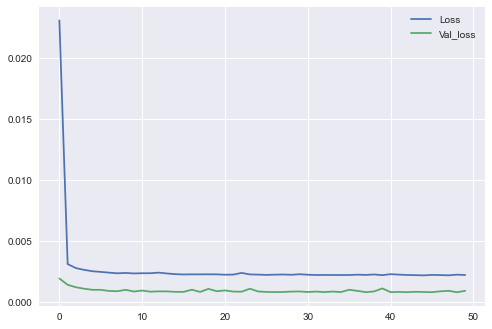

In [21]:
plt.plot(history.history["loss"], label = "Loss")
plt.plot(history.history["val_loss"], label = "Val_loss")
plt.legend()
plt.show()

## Accuracy

In [22]:
def MSE(y_actual, y_predicted):
    mse = np.mean((y_actual - y_predicted)**2)
    return mse

def MAE(y_actual, y_predicted):
    mae = np.mean(abs(y_actual - y_predicted))
    return mae

def MAPE(y_actual, y_predicted):
    mape = np.mean(np.abs((y_actual - y_predicted)/y_actual))*100
    return mape

def RMSE(y_actual, y_predicted):
    rmse = np.sqrt(MSE(y_actual, y_predicted))
    return rmse

In [23]:
test_pred = model.predict(X_test)
mse = round(MSE(y_test, test_pred),5)
mae = round(MAE(y_test, test_pred),5)
mape = round(MAPE(y_test, test_pred),5)
rmse = round(RMSE(y_test, test_pred),5)
print("MSE: ",mse)
print("MAE: ",mae)
print("MAPE: ",mape)
print("RMSE: ",rmse)

MSE:  0.00127
MAE:  0.02479
MAPE:  4.18163
RMSE:  0.0357


## Store accuracy data

In [2]:
field_names = ["MSE", "MAE", "MAPE", "RMSE"]

In [25]:
new_row={'MSE':mse,'MAE': mae,'MAPE': mape,'RMSE':rmse}

In [3]:
file_route = 'Accuracy_15/CNN-LSTM.csv'

In [4]:
from csv import DictWriter

with open(file_route, 'a', encoding='UTF8') as f_object:
    
    dictwriter_object = DictWriter(f_object, fieldnames=field_names)

    dictwriter_object.writerow(new_row)
  
    f_object.close()

NameError: name 'new_row' is not defined

In [5]:
accuracy_CNN_LSTM = pd.read_csv(file_route)
accuracy_LSTM = pd.read_csv('Accuracy_15/LSTM.csv')
accuracy_CNN_LSTM

,MSE,MAE,MAPE,RMSE
0,0.00119,0.02325,3.88428,0.03449
1,0.00121,0.02360,3.95832,0.03475
2,0.00119,0.02313,3.85261,0.03443
3,0.00120,0.02328,3.85571,0.03457
4,0.00146,0.02804,4.55852,0.03827
5,0.00119,0.02316,3.84533,0.03448
6,0.00122,0.02380,3.99658,0.03489
7,0.00129,0.02510,4.23802,0.03595
8,0.00121,0.02356,3.89174,0.03478
9,0.00119,0.02333,3.90260,0.03455


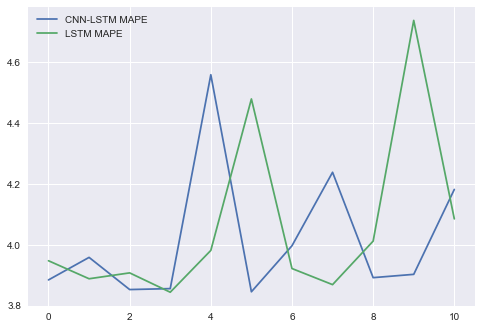

In [29]:
plt.plot(accuracy_CNN_LSTM["MAPE"], label = "CNN-LSTM MAPE")
plt.plot(accuracy_LSTM["MAPE"], label = "LSTM MAPE")
plt.legend()
plt.show()

In [7]:
average = accuracy_LSTM.mean()
average

MSE     0.001262
MAE     0.024511
MAPE    4.061023
RMSE    0.035506
dtype: float64